# Aplicação de Modelos de Markov e Redes Neurais LSTM na Previsão de Arrecadação do ICMS Paulista
## Resultados 2022 

### Antonio Sergio Ferreira Bonato

Atualmente, na Secretaria da Fazenda e Planejamento do Estado de São Paulo, a previsão de arrecadação do ICMS paulista é feita usando-se um modelo ARIMA com variáveis exógenas, o ARIMAX. Mas o ICMS é não linear e há várias quebras estruturais controladas com diversas *dummies*. A consequência é um modelo bastante sobreajustado, inadequado para previsões de mais longo prazo (mais do que alguns meses, muito menos para um ano). 
A proposta deste trabalho é utilizar modelos não lineares multivariados na previsão do ICMS paulista, utilizando redes neurais recorrentes LSTM (*Long Short Term Memory*) e modelos Markov-Switching, fazendo um contraponto entre estes dois modelos. E utilizar, como baseline de comparação, o modelo ARIMAX atual. 

**Palavras-chave**: Markov-Switching Models. Redes Neurais Recorrentes. LSTM. ICMS.

## Treinamento das Redes Neurais - Série Univariada

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools
import statsmodels.tsa.x13
import statsmodels.graphics.tsaplots
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.arima.model import ARIMA
import pickle
from pmdarima.arima import auto_arima, nsdiffs, ndiffs
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

sns.set()
sns.set_context("notebook")
sns.set(rc={'figure.figsize':(10,7)})

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
df_main_orig = pd.read_excel("variaveis_previsao.xlsx", parse_dates=['date'])

Removendo as últimas linhas que são todas NaN

In [4]:
df_main = df_main_orig.iloc[0:240]
datas = df_main['date']

In [5]:
df_main.tail()

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,dolar_21,ibc_br_21
235,2022-08-01,1.756224e+10,1185.004,5.143287,149.60,23,1137.167829,5.6496,146.408337,NaN,NaN,NaN
236,2022-09-01,1.726287e+10,1173.793,5.236957,144.44,21,1143.597376,5.6800,142.808302,NaN,NaN,NaN
237,2022-10-01,1.565000e+10,1162.391,5.250300,142.34,20,1150.115881,5.6700,144.063428,NaN,NaN,NaN
238,2022-11-01,1.605000e+10,1155.829,5.274650,140.80,20,1155.866460,5.6000,143.165409,NaN,NaN,NaN
239,2022-12-01,1.767135e+10,1161.006,5.242432,142.78,22,1161.645792,5.6000,141.405133,NaN,NaN,NaN


### Criação das Séries

In [6]:
icms_ts = pd.Series(list(df_main['icms_sp']), index = datas)

#### Testes de Valores Nulos

In [7]:
print('ICMS', icms_ts.isnull().sum())

ICMS 0


In [8]:
# listando os nulos do icms
icms_ts[icms_ts.isnull()]

Series([], dtype: float64)

In [9]:
# eliminando os nulos do icms
icms_ts = icms_ts[~icms_ts.isnull()]

In [10]:
icms_ts.shape

(240,)

### Série em Log
Como os valores do ICMS são muito elevados a série será colocada em log.

In [11]:
l_icms_ts = pd.Series(np.log(list(df_main['icms_sp'])), index = datas)

## Divisão em treino e teste

In [12]:
icms_train = icms_ts[:-24]
icms_val = icms_ts[-24:-12]
icms_test = icms_ts[-12:]

## Utilidades para Previsões

Além de MAPE e MSE, será usado o erro relativo, que é 

$Erro Relativo = \frac{|previsão - real|}{real}$

In [13]:
def erro_relativo(prev, real):
    return 100*np.absolute(prev-real)/real

#### Dicionário de Previsões
Será usado para armazenar todas as previsões.

In [14]:
previsoes = {
    'nome':[],
    'modelo': [],
    'previsoes': [],
    'rmse': [],
    'mape': [],
    'erro relativo':[]
}

## Modelos RNN LSTM
Redes Neurais Recorrentes com neurônios Long Short-Term Memory

### Montagem da Série
As redes neurais precisam de conjuntos de características e de etiquetas separados. Neste caso, o conjunto de etiquetas é a própria série de ICMS. Para os conjunto de caraterísticas será utilizada a série do ICMS com lags 1, 2, 3, 4, 6 e 12 defasagens, e médias móveis de 2, 3, 6 e 12 meses, conforme trabalho de [Silva & Figueiredo, 2020].

In [15]:
def cria_features_target(serie, verbose=0):
    serie_d1 = serie.shift(1)
    serie_d2 = serie.shift(2)
    serie_d3 = serie.shift(3)
    serie_d4 = serie.shift(4)
    serie_d6 = serie.shift(6)
    serie_d12 = serie.shift(12)
    serie_ma2 = serie.rolling(2).mean()
    serie_ma3 = serie.rolling(3).mean()
    serie_ma6 = serie.rolling(6).mean()
    serie_ma12 = serie.rolling(12).mean()

    if verbose==1:
        print("shape de cada uma das séries:")
        print(serie_d1.shape, serie_d2.shape, serie_d3.shape, serie_d4.shape, 
              serie_d6.shape, serie_d12.shape, serie_ma2.shape, serie_ma3.shape, 
              serie_ma6.shape, serie_ma12.shape)
    X = np.array([serie_d1, serie_d2, serie_d3, serie_d4, 
     serie_d6, serie_d12, serie_ma2, serie_ma3, 
     serie_ma6, serie_ma12])
    if verbose==1:
        print("shape do array de features:", X.shape)
    X = X[:,12:]
    X = X.T
    if verbose==1:
        print("shape do array de features depois da poda e da transposição:", X.shape)
    Y = np.array(serie[12:])
    if verbose==1:
        print("shape do array target:", Y.shape)
    return X, Y

In [16]:
#série completa, com sazonalidade e em nível
#seas_icms_ts = seas_icms.seasadj
X_data, Y_data = cria_features_target(l_icms_ts, verbose=1)

shape de cada uma das séries:
(240,) (240,) (240,) (240,) (240,) (240,) (240,) (240,) (240,) (240,)
shape do array de features: (10, 240)
shape do array de features depois da poda e da transposição: (228, 10)
shape do array target: (228,)


In [17]:
#print(X_data[0])
#print(Y_data[0])
#print(X_data[X_data.shape[0]-1])
#print(Y_data[X_data.shape[0]-1])

#### Normalização dos Dados
Serão normalizados usando-se min-max. Apenas as features, a variável target não será normalizada. Os dados serão dividos em treno, validação e teste para a normalização, de modo que o fit seja feito somente nos dados de treino, aumentando-se assim a probabilidade de generalização do modelo.

In [18]:
X_train = X_data[:-24]
X_val = X_data[-24:-12]
X_test = X_data[-12:]
print(X_train.shape, X_val.shape, X_test.shape)
#Y_train = Y_data[:-24]
#Y_val = Y_data[-24:-12]
#Y_test = Y_data[-12:]
#print(Y_train.shape, Y_val.shape, Y_test.shape)

(204, 10) (12, 10) (12, 10)


In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
# índice dos atributos numéricos
num_atrib = list(range(10))
print('numéricas', num_atrib)

enc_x = ColumnTransformer([('min-max',MinMaxScaler(), num_atrib)], verbose=True)

print(enc_x)
X_train_std = enc_x.fit_transform(X_train)
X_val_std = enc_x.transform(X_val)
X_test_std = enc_x.transform(X_test)

print(X_train_std.shape)
print(X_val_std.shape)
print(X_test_std.shape)

#enc_y = MinMaxScaler()

#print(enc_y)
#Y_train_std = enc_y.fit_transform(Y_train.reshape(Y_train.shape[0], 1))
#Y_val_std = enc_y.transform(Y_val.reshape(12,1))
#Y_test_std = enc_y.transform(Y_test.reshape(12,1))

#print(Y_train_std.shape)
#print(Y_val_std.shape)
#print(Y_test_std.shape)

numéricas [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ColumnTransformer(transformers=[('min-max', MinMaxScaler(),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])],
                  verbose=True)
[ColumnTransformer] ....... (1 of 1) Processing min-max, total=   0.0s
(204, 10)
(12, 10)
(12, 10)


# Modelo 1 mês
Neste modelo cada mês será previsto pelos dados do mês anterior

#### Criando as janelas de 12 meses e reshape para LSTM. A arrecadação de cada mês será prevista pela arrecadação dos 12 meses anteriores.

In [20]:
X_data_jn = np.concatenate((X_train_std, X_val_std, X_test_std), axis = 0)
X_data_jn = X_data_jn.reshape(X_data_jn.shape[0],10,1)
print(X_data_jn.shape)

(228, 10, 1)


In [21]:
def janelamento_1_mes(X, Y, verbose=0):
    X_exp = np.roll(X, 1, axis=0)
    X_exp_cut = X_exp[1:,:,:]#.transpose(0,2,1)
    Y_cut = Y[1:]
    if verbose==1:
        print('shape das features janeladas:', X_exp.shape)
        print('shape das features janeladas pós poda e transposição:', X_exp_cut.shape)
        print('shape do array target pós poda:', Y_cut.shape)
    return X_exp_cut, Y_cut

In [22]:
X_data_exp_cut1, Y_data_cut1 = janelamento_1_mes(X_data_jn, Y_data, verbose=0)

In [23]:
X_data_exp_cut1.shape, Y_data_cut1.shape

((227, 10, 1), (227,))

In [24]:
X_data_exp_cut1[0]

array([[0.13327008],
       [0.04541673],
       [0.03441162],
       [0.01694149],
       [0.00819836],
       [0.05603288],
       [0.07789187],
       [0.04752486],
       [0.        ],
       [0.        ]])

In [25]:
Y_data_cut1[0]

21.905893928886627

In [26]:
Y_data_cut1[Y_data_cut1.shape[0]-1]

23.59521060183563

In [27]:
X_data_exp_cut1[Y_data_cut1.shape[0]-1]

array([[1.03945146],
       [1.15076843],
       [1.20783085],
       [1.2024933 ],
       [1.17611786],
       [1.19303758],
       [1.04498213],
       [1.08136256],
       [1.17391569],
       [1.25116028]])

#### Separando novamente em treino, validação e teste

In [28]:
x_train1 = X_data_exp_cut1[:-24]
x_val1 = X_data_exp_cut1[-24:-12]
x_test1 = X_data_exp_cut1[-12:]
print(x_train1.shape, x_val1.shape, x_test1.shape)
y_train1 = Y_data_cut1[:-24]
y_val1 = Y_data_cut1[-24:-12]
y_test1 = Y_data_cut1[-12:]
print(y_train1.shape, y_val1.shape, y_test1.shape)

(203, 10, 1) (12, 10, 1) (12, 10, 1)
(203,) (12,) (12,)


### Criando o modelo LSTM 

In [29]:
# importando as bibliotecas do Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

## Arquitetura da Rede - Arquitetura Larga

In [30]:
rlrop1 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
early_stop1 = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

In [31]:
# Épocas e percentual de validação
EPOCHS = 700

# Imstanciação do modelo
model = Sequential()

# Adicionar camada LSTM 
model.add(LSTM(activation='tanh', dropout=0.25,
        input_shape = (10, 1), return_sequences = False,
        units = 600))

# Adicionar a camada de saída com 1 neurônio linear
model.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model.compile(loss = 'mape', optimizer = Adam(learning_rate=1e-5))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 600)               1444800   
_________________________________________________________________
dense (Dense)                (None, 1)                 601       
Total params: 1,445,401
Trainable params: 1,445,401
Non-trainable params: 0
_________________________________________________________________


In [33]:
# History object for plotting our model loss by epoch
history1 = model.fit(x_train1, y_train1, batch_size = 4, 
                    epochs = EPOCHS, validation_data = (x_val1, y_val1),
                    callbacks = [rlrop1, early_stop1])

Epoch 1/700
51/51 [==============================] - 2s 31ms/step - loss: 99.8378 - val_loss: 99.3130
Epoch 2/700
51/51 [==============================] - 1s 23ms/step - loss: 99.2723 - val_loss: 98.2459
Epoch 3/700
51/51 [==============================] - 1s 24ms/step - loss: 98.4713 - val_loss: 96.4196
Epoch 4/700
51/51 [==============================] - 1s 24ms/step - loss: 96.6407 - val_loss: 91.8031
Epoch 5/700
51/51 [==============================] - 1s 24ms/step - loss: 91.6339 - val_loss: 73.5865
Epoch 6/700
51/51 [==============================] - 1s 25ms/step - loss: 66.2719 - val_loss: 16.4645
Epoch 7/700
51/51 [==============================] - 1s 25ms/step - loss: 23.3467 - val_loss: 3.5856
Epoch 8/700
51/51 [==============================] - 1s 26ms/step - loss: 8.4645 - val_loss: 0.3916
Epoch 9/700
51/51 [==============================] - 1s 26ms/step - loss: 4.0728 - val_loss: 0.8417
Epoch 10/700
51/51 [==============================] - 1s 27ms/step - loss: 2.2124 - val

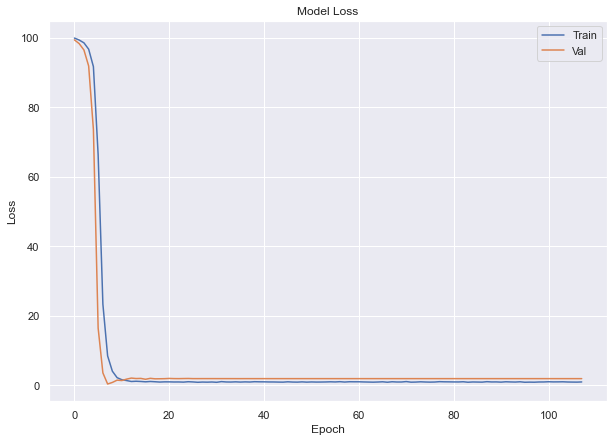

In [34]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão Multistep 12 meses em Validação
Para ficar adequado à realidade, não podemos usar os dados de 2022 para prever 2022. Portanto, a previsão de 2022 será feita do moto *multistep*, isto é, o mês de janeiro/2022 será previsto usando-se os dados de arrecadação de janeiro a dezembro de 2021; o mês de fevereiro/2022 será previsto usando-se os dados de fevereiro a dezembro de 2021 mais a previsão feita para o mês de janeiro/2022; o mês de março/2022 será previsto usando-se os dados de março a dezembro de 2021 mais os meses de janeiro e fevereiro de 2022 previstos nos passos anteriores. E assim por diante, até que a previsão de dezembro/2022 será feita usando-se os dados de dezembro de 2021 mais as previsões de janeiro a novembro de 2022 feitas nos passos anteriores.

#### Remove os 12 últimos valores que serão previstos e cria as séries novamente

In [35]:
# remove
serie_multi1 = l_icms_ts[:-24]
print(l_icms_ts.shape)
print(serie_multi1.shape)

(240,)
(216,)


In [36]:
for i in range(12):
    # cria as séries
    X_multi1, Y_multi1 = cria_features_target(serie_multi1, verbose=0)

    # Faz a normalização usando o modelo fitado na normalização anterior
    X_multi_std1 = enc_x.transform(X_multi1)
    X_multi_std1 = X_multi_std1.reshape(X_multi_std1.shape[0],10,1)

    # Faz o janelamento das séries
    x_multi1, y_multi1 = janelamento_1_mes(X_multi_std1, Y_multi1, verbose=0)

    # Faz a predição da arrecadação do mês
    #y_pred_multi = np.mean(model.predict(x_multi[-1:]), axis=1)#[:,0].ravel()
    y_pred_multi1 = model.predict(x_multi1[-1:])#[:,0].ravel()
    print(i, np.exp(y_pred_multi1))

    #### Adicionar o valor previsto à série e fazer o novo janelamento
    serie_multi1 = pd.Series(np.append(serie_multi1, y_pred_multi1))

0 [[1.5949099e+10]]
1 [[1.6294623e+10]]
2 [[1.647906e+10]]
3 [[1.669791e+10]]
4 [[1.6836708e+10]]
5 [[1.693116e+10]]
6 [[1.7000701e+10]]
7 [[1.7020332e+10]]
8 [[1.7031632e+10]]
9 [[1.7039301e+10]]
10 [[1.7040048e+10]]
11 [[1.7037447e+10]]


In [37]:
Y_pred_multi1 = np.exp(pd.Series(serie_multi1[-12:]))
Y_pred_multi1.index = icms_val.index

In [38]:
Y_pred_multi1

date
2021-01-01    1.594910e+10
2021-02-01    1.629462e+10
2021-03-01    1.647906e+10
2021-04-01    1.669791e+10
2021-05-01    1.683671e+10
2021-06-01    1.693116e+10
2021-07-01    1.700070e+10
2021-08-01    1.702033e+10
2021-09-01    1.703163e+10
2021-10-01    1.703930e+10
2021-11-01    1.704005e+10
2021-12-01    1.703745e+10
dtype: float64

In [39]:
RMSE_lstm_multi1 = mean_squared_error(icms_val, Y_pred_multi1, squared=False)
RMSE_lstm_multi1

1831322678.5981617

In [40]:
MAPE_lstm_multi1 = mean_absolute_percentage_error(icms_val, Y_pred_multi1)
MAPE_lstm_multi1

0.10974761611244617

In [41]:
previsoes['nome'].append('RNN-LSTM-1-mês-larga')
previsoes['modelo'].append(model)
previsoes['previsoes'].append(Y_pred_multi1)

previsoes['rmse'].append(RMSE_lstm_multi1)

previsoes['mape'].append(MAPE_lstm_multi1)

previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(Y_pred_multi1
                                                        , icms_val)])

## Arquitetura da Rede - Arquitetura Multicamada

In [42]:
rlrop3 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25, verbose=1)
early_stop3 = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

In [43]:
# Épocas e percentual de validação
EPOCHS3 = 700

# Imstanciação do modelo
model3 = Sequential()

# Adicionar camada LSTM 
model3.add(LSTM(activation='tanh', dropout=0.15,
        input_shape = (10, 1), return_sequences = True,
        units = 300))

# Adicionar camada LSTM 
model3.add(LSTM(activation='tanh', dropout=0.15,
        input_shape = (10, 1), return_sequences = False,
        units = 300))


# Adicionar a camada de saída com 1 neurônio linear
model3.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model3.compile(loss = 'mape', optimizer = Adam(learning_rate=1e-4))

In [44]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 300)           362400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 1,083,901
Trainable params: 1,083,901
Non-trainable params: 0
_________________________________________________________________


In [45]:
# History object for plotting our model loss by epoch
history3 = model3.fit(x_train1, y_train1, batch_size = 16, 
                    epochs = EPOCHS, validation_data = (x_val1, y_val1),
                    callbacks = [rlrop1, early_stop1])

Epoch 1/700
13/13 [==============================] - 1s 76ms/step - loss: 99.6440 - val_loss: 98.1224
Epoch 2/700
13/13 [==============================] - 0s 25ms/step - loss: 97.8223 - val_loss: 93.5657
Epoch 3/700
13/13 [==============================] - 0s 27ms/step - loss: 92.3559 - val_loss: 75.4085
Epoch 4/700
13/13 [==============================] - 0s 29ms/step - loss: 70.0827 - val_loss: 32.4815
Epoch 5/700
13/13 [==============================] - 0s 28ms/step - loss: 29.0255 - val_loss: 9.8745
Epoch 6/700
13/13 [==============================] - 0s 27ms/step - loss: 5.5998 - val_loss: 1.5635
Epoch 7/700
13/13 [==============================] - 0s 28ms/step - loss: 1.3620 - val_loss: 0.9885
Epoch 8/700
13/13 [==============================] - 0s 26ms/step - loss: 0.9849 - val_loss: 2.5666
Epoch 9/700
13/13 [==============================] - 0s 27ms/step - loss: 0.8972 - val_loss: 2.1669
Epoch 10/700
13/13 [==============================] - 0s 27ms/step - loss: 0.8059 - val_los

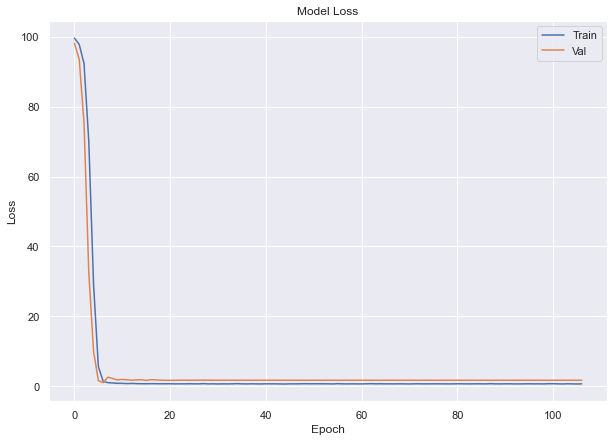

In [46]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão Multistep 12 meses em Validação
Para ficar adequado à realidade, não podemos usar os dados de 2022 para prever 2022. Portanto, a previsão de 2022 será feita do moto *multistep*, isto é, o mês de janeiro/2022 será previsto usando-se os dados de arrecadação de janeiro a dezembro de 2021; o mês de fevereiro/2022 será previsto usando-se os dados de fevereiro a dezembro de 2021 mais a previsão feita para o mês de janeiro/2022; o mês de março/2022 será previsto usando-se os dados de março a dezembro de 2021 mais os meses de janeiro e fevereiro de 2022 previstos nos passos anteriores. E assim por diante, até que a previsão de dezembro/2022 será feita usando-se os dados de dezembro de 2021 mais as previsões de janeiro a novembro de 2022 feitas nos passos anteriores.

#### Remove os 12 últimos valores que serão previstos e cria as séries novamente

In [47]:
# remove
serie_multi12 = l_icms_ts[:-24]
print(l_icms_ts.shape)
print(serie_multi1.shape)

(240,)
(228,)


In [48]:
for i in range(12):
    # cria as séries
    X_multi12, Y_multi12 = cria_features_target(serie_multi12, verbose=0)

    # Faz a normalização usando o modelo fitado na normalização anterior
    X_multi_std12 = enc_x.transform(X_multi12)
    X_multi_std12 = X_multi_std12.reshape(X_multi_std12.shape[0],10,1)

    # Faz o janelamento das séries
    x_multi12, y_multi12 = janelamento_1_mes(X_multi_std12, Y_multi12, verbose=0)

    # Faz a predição da arrecadação do mês
    #y_pred_multi = np.mean(model.predict(x_multi[-1:]), axis=1)#[:,0].ravel()
    y_pred_multi12 = model3.predict(x_multi12[-1:])#[:,0].ravel()
    print(i, np.exp(y_pred_multi12))

    #### Adicionar o valor previsto à série e fazer o novo janelamento
    serie_multi12 = pd.Series(np.append(serie_multi12, y_pred_multi12))

0 [[1.2151244e+10]]
1 [[1.2181155e+10]]
2 [[1.2197895e+10]]
3 [[1.2176626e+10]]
4 [[1.2159821e+10]]
5 [[1.2142857e+10]]
6 [[1.213038e+10]]
7 [[1.213251e+10]]
8 [[1.2127396e+10]]
9 [[1.212839e+10]]
10 [[1.2129339e+10]]
11 [[1.2130126e+10]]


In [49]:
Y_pred_multi12 = np.exp(pd.Series(serie_multi12[-12:]))
Y_pred_multi12.index = icms_val.index

In [50]:
Y_pred_multi12

date
2021-01-01    1.215124e+10
2021-02-01    1.218116e+10
2021-03-01    1.219790e+10
2021-04-01    1.217663e+10
2021-05-01    1.215982e+10
2021-06-01    1.214286e+10
2021-07-01    1.213038e+10
2021-08-01    1.213251e+10
2021-09-01    1.212740e+10
2021-10-01    1.212839e+10
2021-11-01    1.212934e+10
2021-12-01    1.213013e+10
dtype: float64

In [51]:
RMSE_lstm_multi12 = mean_squared_error(icms_val, Y_pred_multi12, squared=False)
RMSE_lstm_multi12

3640152273.301945

In [52]:
MAPE_lstm_multi12 = mean_absolute_percentage_error(icms_val, Y_pred_multi12)
MAPE_lstm_multi12

0.2074872831447729

In [53]:
previsoes['nome'].append('RNN-LSTM-1-mês-camadas')
previsoes['modelo'].append(model3)
previsoes['previsoes'].append(Y_pred_multi12)

previsoes['rmse'].append(RMSE_lstm_multi12)

previsoes['mape'].append(MAPE_lstm_multi12)

previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(Y_pred_multi12
                                                        , icms_val)])

# Modelo 12 meses

#### Criando as janelas de 12 meses e reshape para LSTM. A arrecadação de cada mês será prevista pela arrecadação dos 12 meses anteriores.

##### Unindo novamente os dados.

In [54]:
def janelamento_12_meses(X, Y, verbose=0):
    X_exp = np.concatenate((np.roll(X, 12, axis=0),
                            np.roll(X, 11, axis=0),
                            np.roll(X, 10, axis=0),
                            np.roll(X, 9, axis=0),
                            np.roll(X, 8, axis=0),
                            np.roll(X, 7, axis=0),
                            np.roll(X, 6, axis=0),
                            np.roll(X, 5, axis=0),
                            np.roll(X, 4, axis=0),
                            np.roll(X, 3, axis=0),
                            np.roll(X, 2, axis=0),
                            np.roll(X, 1, axis=0),
                            ), axis=2)
    X_exp_cut = X_exp[12:,:,:].transpose(0,2,1)
    Y_cut = Y[12:]
    if verbose==1:
        print('shape das features janeladas:', X_exp.shape)
        print('shape das features janeladas pós poda e transposição:', X_exp_cut.shape)
        print('shape do array target pós poda:', Y_cut.shape)
    return X_exp_cut, Y_cut

In [55]:
X_data_exp_cut12, Y_data_cut12 = janelamento_12_meses(X_data_jn, Y_data, verbose=0)

In [56]:
#Y_data_cut[0]

In [57]:
#X_data_exp_cut[0]

In [58]:
#Y_data_cut[Y_data_cut.shape[0]-1]

In [59]:
#X_data_exp_cut[Y_data_cut.shape[0]-1]

#### Separando novamente em treino, validação e teste

In [60]:
x_train12 = X_data_exp_cut12[:-24]
x_val12 = X_data_exp_cut12[-24:-12]
x_test12 = X_data_exp_cut12[-12:]
print(x_train12.shape, x_val12.shape, x_test12.shape)
y_train12 = Y_data_cut12[:-24]
y_val12 = Y_data_cut12[-24:-12]
y_test12 = np.exp(Y_data_cut12[-12:]) # tirar o log para ficar o valor real
print(y_train12.shape, y_val12.shape, y_test12.shape)

(192, 12, 10) (12, 12, 10) (12, 12, 10)
(192,) (12,) (12,)


### Criando o modelo LSTM

## Arquitetura da Rede - Arquitetura Larga

In [61]:
rlrop2 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
early_stop2 = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

In [62]:
# Épocas e percentual de validação
EPOCHS2 = 700

# Imstanciação do modelo
model2 = Sequential()

# Adicionar camada LSTM 
model2.add(LSTM(activation='tanh', dropout=0.25,
        input_shape = (12, 10), return_sequences = False,
        units = 600))

# Adicionar a camada de saída com 1 neurônio linear
model2.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model2.compile(loss = 'mape', optimizer = Adam(learning_rate=1e-5))

In [63]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 600)               1466400   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 601       
Total params: 1,467,001
Trainable params: 1,467,001
Non-trainable params: 0
_________________________________________________________________


In [64]:
# History object for plotting our model loss by epoch
history2 = model2.fit(x_train12, y_train12, batch_size = 4, 
                    epochs = EPOCHS2, validation_data = (x_val12, y_val12),
                    callbacks = [rlrop2, early_stop2])

Epoch 1/700
48/48 [==============================] - 2s 36ms/step - loss: 99.4873 - val_loss: 97.6153
Epoch 2/700
48/48 [==============================] - 1s 28ms/step - loss: 97.2799 - val_loss: 93.3537
Epoch 3/700
48/48 [==============================] - 1s 30ms/step - loss: 93.2115 - val_loss: 83.2717
Epoch 4/700
48/48 [==============================] - 1s 30ms/step - loss: 80.9212 - val_loss: 51.5310
Epoch 5/700
48/48 [==============================] - 1s 30ms/step - loss: 48.9285 - val_loss: 16.6971
Epoch 6/700
48/48 [==============================] - 1s 31ms/step - loss: 18.3538 - val_loss: 0.3713
Epoch 7/700
48/48 [==============================] - 2s 31ms/step - loss: 7.2160 - val_loss: 1.1068
Epoch 8/700
48/48 [==============================] - 2s 32ms/step - loss: 4.5489 - val_loss: 1.2433
Epoch 9/700
48/48 [==============================] - 2s 31ms/step - loss: 2.8802 - val_loss: 1.7536
Epoch 10/700
48/48 [==============================] - 2s 33ms/step - loss: 2.1550 - val_l

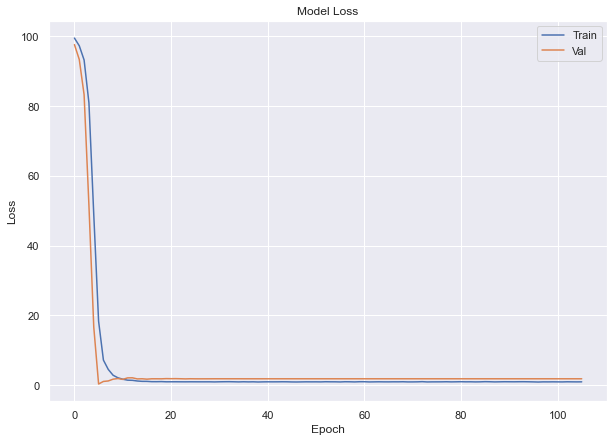

In [65]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão Multistep 12 meses em Validação
Para ficar adequado à realidade, não podemos usar os dados de 2022 para prever 2022. Portanto, a previsão de 2022 será feita do moto *multistep*, isto é, o mês de janeiro/2022 será previsto usando-se os dados de arrecadação de janeiro a dezembro de 2021; o mês de fevereiro/2022 será previsto usando-se os dados de fevereiro a dezembro de 2021 mais a previsão feita para o mês de janeiro/2022; o mês de março/2022 será previsto usando-se os dados de março a dezembro de 2021 mais os meses de janeiro e fevereiro de 2022 previstos nos passos anteriores. E assim por diante, até que a previsão de dezembro/2022 será feita usando-se os dados de dezembro de 2021 mais as previsões de janeiro a novembro de 2022 feitas nos passos anteriores.

#### Remove os 12 últimos valores que serão previstos e cria as séries novamente

In [66]:
# remove
serie_multi12 = l_icms_ts[:-24]
print(l_icms_ts.shape)
print(serie_multi12.shape)
type(serie_multi12)

(240,)
(216,)


pandas.core.series.Series

In [67]:
for i in range(12):
    # cria as séries
    X_multi12, Y_multi12 = cria_features_target(serie_multi12, verbose=0)

    # Faz a normalização usando o modelo fitado na normalização anterior
    X_multi_std12 = enc_x.transform(X_multi12)
    X_multi_std12 = X_multi_std12.reshape(X_multi_std12.shape[0],10,1)

    # Faz o janelamento das séries
    x_multi12, y_multi12 = janelamento_12_meses(X_multi_std12, Y_multi12, verbose=0)

    # Faz a predição da arrecadação do mês
    #y_pred_multi = np.mean(model.predict(x_multi[-1:]), axis=1)#[:,0].ravel()
    y_pred_multi12 = model2.predict(x_multi12[-1:])#[:,0].ravel()
    print(i, np.exp(y_pred_multi12))

    #### Adicionar o valor previsto à série e fazer o novo janelamento
    serie_multi12 = pd.Series(np.append(serie_multi12, y_pred_multi12))
    type(serie_multi12)

0 [[1.6698865e+10]]
1 [[1.6705078e+10]]
2 [[1.6616861e+10]]
3 [[1.6496953e+10]]
4 [[1.6346734e+10]]
5 [[1.6157305e+10]]
6 [[1.6071399e+10]]
7 [[1.6150711e+10]]
8 [[1.6313406e+10]]
9 [[1.6554479e+10]]
10 [[1.6788062e+10]]
11 [[1.6996909e+10]]


In [68]:
Y_pred_multi12 = np.exp(pd.Series(serie_multi12[-12:])) # tira o log das previsões
Y_pred_multi12.index = icms_val.index

In [69]:
Y_pred_multi12

date
2021-01-01    1.669887e+10
2021-02-01    1.670508e+10
2021-03-01    1.661686e+10
2021-04-01    1.649695e+10
2021-05-01    1.634673e+10
2021-06-01    1.615731e+10
2021-07-01    1.607140e+10
2021-08-01    1.615071e+10
2021-09-01    1.631341e+10
2021-10-01    1.655448e+10
2021-11-01    1.678806e+10
2021-12-01    1.699691e+10
dtype: float64

In [70]:
RMSE_lstm_multi12 = mean_squared_error(icms_val, Y_pred_multi12, squared=False)
RMSE_lstm_multi12

1750161810.16003

In [71]:
MAPE_lstm_multi12 = mean_absolute_percentage_error(icms_val, Y_pred_multi12)
MAPE_lstm_multi12

0.09559669801454583

In [72]:
previsoes['nome'].append('RNN-LSTM-12-meses-larga')
previsoes['modelo'].append(model2)
previsoes['previsoes'].append(Y_pred_multi12)

previsoes['rmse'].append(RMSE_lstm_multi12)

previsoes['mape'].append(MAPE_lstm_multi12)

In [73]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(Y_pred_multi12
                                                        , icms_val)])

## Arquitetura da Rede - Arquitetura Multicamada

In [74]:
rlrop4 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25, verbose=1)
early_stop4 = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

In [75]:
# Épocas e percentual de validação
EPOCHS4 = 700

# Imstanciação do modelo
model4 = Sequential()

# Adicionar camada LSTM 
model4.add(LSTM(activation='tanh', dropout=0.15,
        input_shape = (12, 10), return_sequences = True,
        units = 300))

# Adicionar camada LSTM 
model4.add(LSTM(activation='tanh', dropout=0.15,
        input_shape = (12, 10), return_sequences = False,
        units = 300))


# Adicionar a camada de saída com 1 neurônio linear
model4.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model4.compile(loss = 'mape', optimizer = Adam(learning_rate=1e-4))

In [76]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 12, 300)           373200    
_________________________________________________________________
lstm_5 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 301       
Total params: 1,094,701
Trainable params: 1,094,701
Non-trainable params: 0
_________________________________________________________________


In [77]:
# History object for plotting our model loss by epoch
history4 = model4.fit(x_train12, y_train12, batch_size = 16, 
                    epochs = EPOCHS4, validation_data = (x_val12, y_val12),
                    callbacks = [rlrop4, early_stop4])

Epoch 1/700
12/12 [==============================] - 1s 76ms/step - loss: 97.2459 - val_loss: 90.5817
Epoch 2/700
12/12 [==============================] - 0s 25ms/step - loss: 88.3507 - val_loss: 69.2322
Epoch 3/700
12/12 [==============================] - 0s 26ms/step - loss: 64.9291 - val_loss: 38.1538
Epoch 4/700
12/12 [==============================] - 0s 25ms/step - loss: 34.0540 - val_loss: 18.3598
Epoch 5/700
12/12 [==============================] - 0s 26ms/step - loss: 13.1091 - val_loss: 7.2790
Epoch 6/700
12/12 [==============================] - 0s 26ms/step - loss: 2.7872 - val_loss: 1.7106
Epoch 7/700
12/12 [==============================] - 0s 26ms/step - loss: 1.4288 - val_loss: 1.2238
Epoch 8/700
12/12 [==============================] - 0s 27ms/step - loss: 1.1371 - val_loss: 2.4414
Epoch 9/700
12/12 [==============================] - 0s 27ms/step - loss: 1.0967 - val_loss: 2.4768
Epoch 10/700
12/12 [==============================] - 0s 27ms/step - loss: 1.0709 - val_los

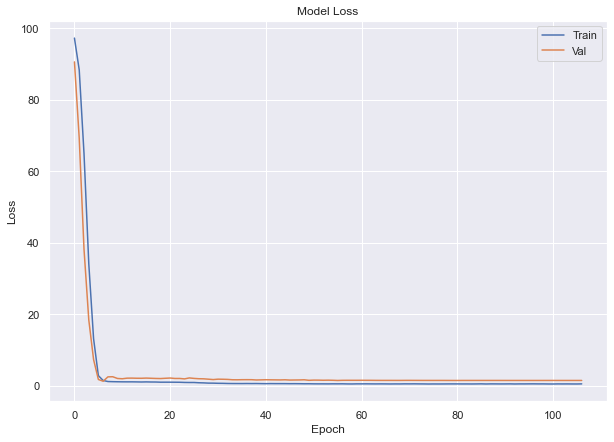

In [78]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão Multistep 12 meses em Validação
Para ficar adequado à realidade, não podemos usar os dados de 2022 para prever 2022. Portanto, a previsão de 2022 será feita do moto *multistep*, isto é, o mês de janeiro/2022 será previsto usando-se os dados de arrecadação de janeiro a dezembro de 2021; o mês de fevereiro/2022 será previsto usando-se os dados de fevereiro a dezembro de 2021 mais a previsão feita para o mês de janeiro/2022; o mês de março/2022 será previsto usando-se os dados de março a dezembro de 2021 mais os meses de janeiro e fevereiro de 2022 previstos nos passos anteriores. E assim por diante, até que a previsão de dezembro/2022 será feita usando-se os dados de dezembro de 2021 mais as previsões de janeiro a novembro de 2022 feitas nos passos anteriores.

#### Remove os 12 últimos valores que serão previstos e cria as séries novamente

In [79]:
# remove
serie_multi122 = l_icms_ts[:-24]
print(l_icms_ts.shape)
print(serie_multi122.shape)
type(serie_multi122)

(240,)
(216,)


pandas.core.series.Series

In [80]:
for i in range(12):
    # cria as séries
    X_multi122, Y_multi122 = cria_features_target(serie_multi122, verbose=0)

    # Faz a normalização usando o modelo fitado na normalização anterior
    X_multi_std122 = enc_x.transform(X_multi122)
    X_multi_std122 = X_multi_std122.reshape(X_multi_std122.shape[0],10,1)

    # Faz o janelamento das séries
    x_multi122, y_multi122 = janelamento_12_meses(X_multi_std122, Y_multi122, verbose=0)

    # Faz a predição da arrecadação do mês
    #y_pred_multi = np.mean(model.predict(x_multi[-1:]), axis=1)#[:,0].ravel()
    y_pred_multi122 = model4.predict(x_multi122[-1:])#[:,0].ravel()
    print(i, np.exp(y_pred_multi122))

    #### Adicionar o valor previsto à série e fazer o novo janelamento
    serie_multi122 = pd.Series(np.append(serie_multi122, y_pred_multi122))
    type(serie_multi122)

0 [[1.1541754e+10]]
1 [[1.1545916e+10]]
2 [[1.1548185e+10]]
3 [[1.1547325e+10]]
4 [[1.1544948e+10]]
5 [[1.1542106e+10]]
6 [[1.1538079e+10]]
7 [[1.153775e+10]]
8 [[1.1537661e+10]]
9 [[1.1538827e+10]]
10 [[1.1539972e+10]]
11 [[1.1540852e+10]]


In [81]:
Y_pred_multi122 = np.exp(pd.Series(serie_multi122[-12:])) # tira o log das previsões
Y_pred_multi122.index = icms_val.index

In [82]:
Y_pred_multi122

date
2021-01-01    1.154175e+10
2021-02-01    1.154592e+10
2021-03-01    1.154818e+10
2021-04-01    1.154733e+10
2021-05-01    1.154495e+10
2021-06-01    1.154211e+10
2021-07-01    1.153808e+10
2021-08-01    1.153775e+10
2021-09-01    1.153766e+10
2021-10-01    1.153883e+10
2021-11-01    1.153997e+10
2021-12-01    1.154085e+10
dtype: float64

In [83]:
RMSE_lstm_multi122 = mean_squared_error(icms_val, Y_pred_multi122, squared=False)
RMSE_lstm_multi122

4195773436.0328603

In [84]:
MAPE_lstm_multi122 = mean_absolute_percentage_error(icms_val, Y_pred_multi122)
MAPE_lstm_multi122

0.24716940715336277

In [85]:
previsoes['nome'].append('RNN-LSTM-12-meses-camadas')
previsoes['modelo'].append(model4)
previsoes['previsoes'].append(Y_pred_multi122)

previsoes['rmse'].append(RMSE_lstm_multi122)

previsoes['mape'].append(MAPE_lstm_multi122)

In [86]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(Y_pred_multi122
                                                        , icms_val)])

## Resultados

In [87]:
previsoes['nome']

['RNN-LSTM-1-mês-larga',
 'RNN-LSTM-1-mês-camadas',
 'RNN-LSTM-12-meses-larga',
 'RNN-LSTM-12-meses-camadas']

In [88]:
df_prev = pd.DataFrame(data=previsoes['previsoes'], 
                       index=previsoes['nome']).transpose()
df_prev["real"] = icms_val
df_rmse = pd.DataFrame(data=previsoes['rmse'], 
                       index=previsoes['nome']).transpose()
df_mape = pd.DataFrame(data=previsoes['mape'], 
                       index=previsoes['nome']).transpose()
df_erro = pd.DataFrame(data=previsoes['erro relativo'], 
                       index=previsoes['nome']).transpose()

In [89]:
df_prev

,RNN-LSTM-1-mês-larga,RNN-LSTM-1-mês-camadas,RNN-LSTM-12-meses-larga,RNN-LSTM-12-meses-camadas,real
date,,,,,
2021-01-01,1.594910e+10,1.215124e+10,1.669887e+10,1.154175e+10,1.413347e+10
2021-02-01,1.629462e+10,1.218116e+10,1.670508e+10,1.154592e+10,1.370153e+10
2021-03-01,1.647906e+10,1.219790e+10,1.661686e+10,1.154818e+10,1.484308e+10
2021-04-01,1.669791e+10,1.217663e+10,1.649695e+10,1.154733e+10,1.366780e+10
2021-05-01,1.683671e+10,1.215982e+10,1.634673e+10,1.154495e+10,1.414623e+10
2021-06-01,1.693116e+10,1.214286e+10,1.615731e+10,1.154211e+10,1.465265e+10
2021-07-01,1.700070e+10,1.213038e+10,1.607140e+10,1.153808e+10,1.570838e+10
2021-08-01,1.702033e+10,1.213251e+10,1.615071e+10,1.153775e+10,1.597532e+10
2021-09-01,1.703163e+10,1.212740e+10,1.631341e+10,1.153766e+10,1.622460e+10


In [90]:
df_erro

,RNN-LSTM-1-mês-larga,RNN-LSTM-1-mês-camadas,RNN-LSTM-12-meses-larga,RNN-LSTM-12-meses-camadas
0,12.846273,14.025071,18.151177,18.337454
1,18.925573,11.096385,21.921258,15.732652
2,11.021801,17.821019,11.950193,22.198215
3,22.169672,10.910146,20.699379,15.514400
4,19.019078,14.041931,15.555440,18.388500
5,15.550134,17.128611,10.268804,21.228553
6,8.226965,22.777647,2.310997,26.548253
7,6.541392,24.054687,1.097876,27.777678
8,4.974104,25.253054,0.547333,28.887872
9,2.395461,27.116014,0.518015,30.658918


#### Previsões

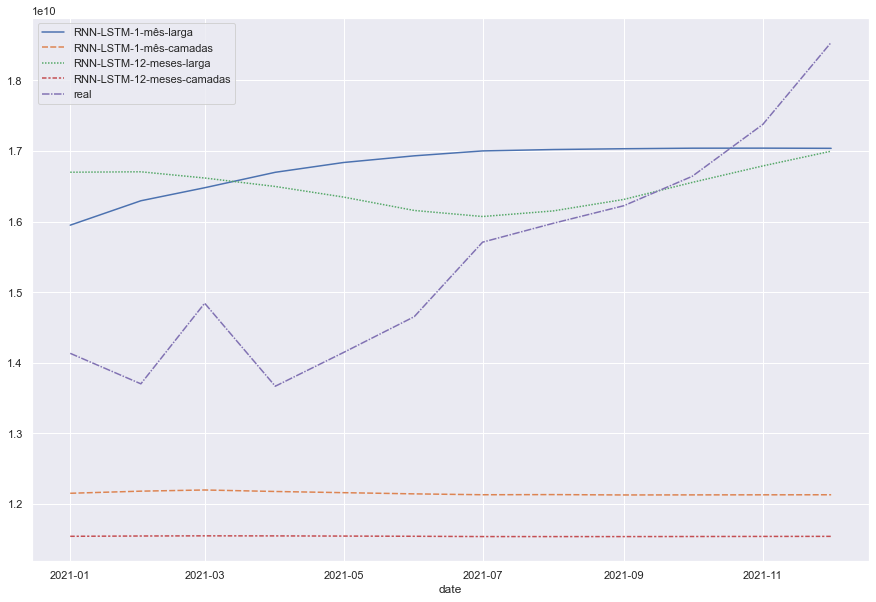

In [91]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=df_prev)

#### RMSE

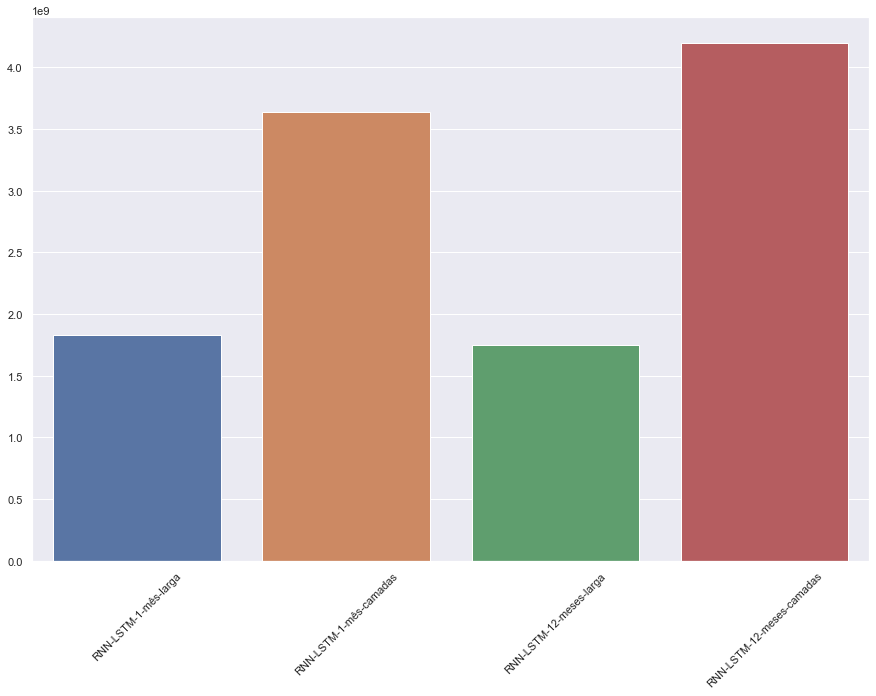

In [92]:
fig = plt.figure(figsize=(15, 10))
#df_rmse = df_rmse.drop(['mov_avg_12'], axis=1)
ax = sns.barplot(data=df_rmse)
_ = plt.xticks(rotation=45)

#### MAPE

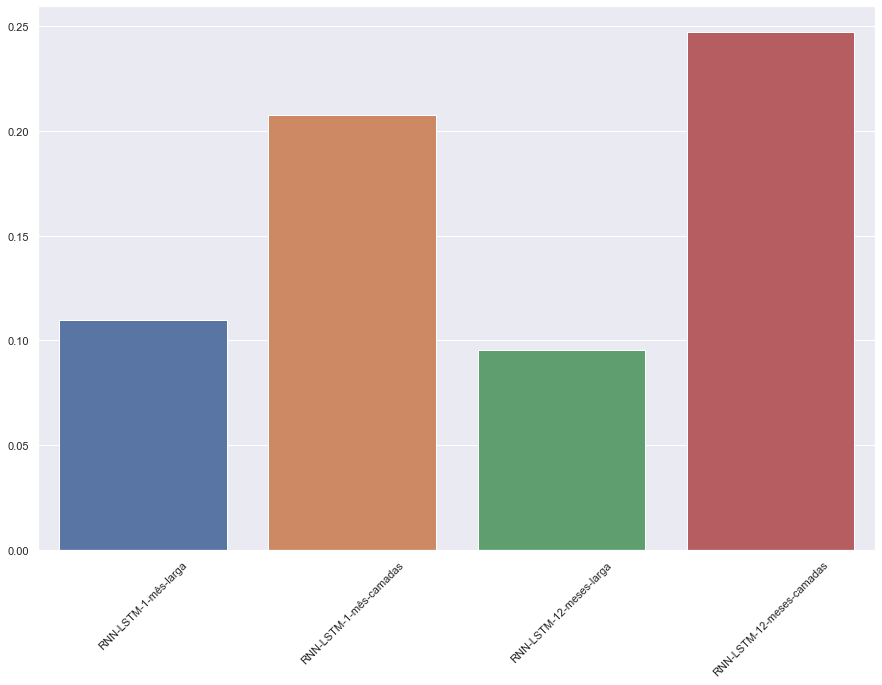

In [93]:
fig = plt.figure(figsize=(15, 10))
#df_mape = df_mape.drop(['mov_avg_12'], axis=1)
ax = sns.barplot(data=df_mape)
_ = plt.xticks(rotation=45)

### Resumo das métricas

In [94]:
df_rmse.index = ['RMSE']
df_mape.index = ['MAPE']

In [95]:
df_metricas = df_rmse.copy()
df_metricas = df_metricas.append(df_mape.copy())
df_metricas

,RNN-LSTM-1-mês-larga,RNN-LSTM-1-mês-camadas,RNN-LSTM-12-meses-larga,RNN-LSTM-12-meses-camadas
RMSE,1.831323e+09,3.640152e+09,1.750162e+09,4.195773e+09
MAPE,1.097476e-01,2.074873e-01,9.559670e-02,2.471694e-01


In [96]:
print(df_metricas.transpose().to_latex())

\begin{tabular}{lrr}
\toprule
{} &          RMSE &      MAPE \\
\midrule
RNN-LSTM-1-mês-larga      &  1.831323e+09 &  0.109748 \\
RNN-LSTM-1-mês-camadas    &  3.640152e+09 &  0.207487 \\
RNN-LSTM-12-meses-larga   &  1.750162e+09 &  0.095597 \\
RNN-LSTM-12-meses-camadas &  4.195773e+09 &  0.247169 \\
\bottomrule
\end{tabular}



In [97]:
print(df_prev['2022-01-01':'2022-04-01'].transpose().to_latex(escape=False))

\begin{tabular}{l}
\toprule
Empty DataFrame
Columns: DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)
Index: Index(['RNN-LSTM-1-mês-larga', 'RNN-LSTM-1-mês-camadas',
       'RNN-LSTM-12-meses-larga', 'RNN-LSTM-12-meses-camadas', 'real'],
      dtype='object') \\
\bottomrule
\end{tabular}



In [98]:
print(df_prev['2022-05-01':'2022-08-01'].transpose().to_latex(escape=False))

\begin{tabular}{l}
\toprule
Empty DataFrame
Columns: DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)
Index: Index(['RNN-LSTM-1-mês-larga', 'RNN-LSTM-1-mês-camadas',
       'RNN-LSTM-12-meses-larga', 'RNN-LSTM-12-meses-camadas', 'real'],
      dtype='object') \\
\bottomrule
\end{tabular}



In [99]:
print(df_prev['2022-09-01':'2022-12-01'].transpose().to_latex(escape=False))

\begin{tabular}{l}
\toprule
Empty DataFrame
Columns: DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)
Index: Index(['RNN-LSTM-1-mês-larga', 'RNN-LSTM-1-mês-camadas',
       'RNN-LSTM-12-meses-larga', 'RNN-LSTM-12-meses-camadas', 'real'],
      dtype='object') \\
\bottomrule
\end{tabular}

